# Training and Infarence
---

The project repo [https://github.com/darkmatter18/Dockship-Attentive-AI-Internship-Hiring-Challenge](https://github.com/darkmatter18/Dockship-Attentive-AI-Internship-Hiring-Challenge)

Please refer to this notebook to know, how I get the Normaliation values [https://github.com/darkmatter18/Dockship-Attentive-AI-Internship-Hiring-Challenge/blob/master/Normalize_and-analize.ipynb](https://github.com/darkmatter18/Dockship-Attentive-AI-Internship-Hiring-Challenge/blob/master/Normalize_and-analize.ipynb)

- [Hyperparameters](#Hyperparameters)
- [Training](#Training)
    1. [Torch Dataset and Dataloader](#Torch-Dataset-and-Dataloader)
        - [Datasets](#Datasets)
        - [Dataloaders](#Dataloaders)
    2. [CUDA](#CUDA)
    3. [Models](#Models)
        1. [Resnet Model](#Resnet-Model)
        2. [Densenet Model](#Densenet-Model)
    4. [Loss and Optimizer](#Loss-and-Optimizer)
    5. [Training](#Training-Loop)
    6. [Training Stats](#Training-Stats)
- [Testing](#Testing)

In [1]:
import os
import datetime
from PIL import Image

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Hyperparameters

In [2]:
CROP_SIZE = 256
IMAGE_SIZE = 224

BATCH_SIZE = 32

LR = 1
EPOCHS = 50

CENTER_CROP_FIVE = True

# Training

In [3]:
# Reading the Datafarme
data = pd.read_csv('./dataset/train_challenge.csv')
data.head()

,0,1
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


In [4]:
# Setup Classes
CLASSES = ['Adhered', 'Ballasted', 'Concrete', 'Plastic & fabric', 'Shingle', 'Steel']

classes_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
idx_to_classes = {idx: cls for idx, cls in enumerate(CLASSES)}

In [5]:
# replace '1' column with classes_to_idx dict
data = data.replace({'1': classes_to_idx})
data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,2
3,3.jpg,2
4,4.jpg,3


In [6]:
# Make X and Y from dataframe
X = data['0'].values
Y = data['1'].values

In [7]:
# Split into train, validation and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

print(f"Train size: {len(X_train)}\nValidation size: {len(X_val)}\n")

Train size: 6915
Validation size: 1729



## Torch Dataset and Dataloader

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, dataroot: str, X_array: np.array, Y_array: np.array, transform = None, target_transform = None):
        self.dataroot = dataroot
        self.X_array = X_array
        self.Y_array = Y_array
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        file_name = self.X_array[index]
        img = Image.open(os.path.join(self.dataroot, file_name)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        label = np.array(self.Y_array[index])
        if self.target_transform is not None:
            label = self.target_transform(label)
        else:
            label = torch.from_numpy(label)

        return {'image': img, 'label': label, 'image_name': file_name}

    def __len__(self):
        return len(self.X_array)

### Datasets

In [9]:
train_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                                 transform=transforms.Compose([transforms.ColorJitter(0.2, 0.2),
                                                               transforms.Resize(CROP_SIZE),
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.RandomCrop(IMAGE_SIZE),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                    [0.2558, 0.2532, 0.2457]),
                                                               transforms.RandomErasing()]))

val_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_val, Y_array=y_val, 
                               transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                             transforms.CenterCrop(IMAGE_SIZE),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                  [0.2558, 0.2532, 0.2457])]))

### Dataloaders

In [10]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## CUDA

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    print(f"Using {torch.cuda.get_device_name()} for Training")
else:
    print("Using CPU for Training")

Using Tesla T4 for Training


## Models

### Resnet Model

In [12]:
class ResnetModel(nn.Module):
    def __init__(self):
        super(ResnetModel, self).__init__()
        r = models.resnet18(pretrained=True)
        fc = nn.Linear(r.fc.in_features, len(CLASSES))
        r.fc = fc
        self.model = r
        
    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

### Densenet Model

In [13]:
class DensenetModel(nn.Module):
    def __init__(self):
        super(DensenetModel, self).__init__()
        m = models.densenet161(pretrained=True)
        fc = nn.Linear(m.classifier.in_features, len(CLASSES))
        m.classifier = fc
        self.model = m
        
    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
model = DensenetModel()
model = model.to(device)
model

DensenetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentu

## Loss and Optimizer

In [15]:
# Loss
criterion = nn.NLLLoss().cuda() if torch.cuda.is_available() else nn.NLLLoss()

# Optimizer
# optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))

## LR scheduler

In [16]:
LR_START = 1e-5
LR_MAX = 7e-5 
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 7
LR_SUSTAIN_EPOCHS = 0 # 3
LR_EXP_DECAY = 0.80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
        lr = LR_MAX
    else:
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

In [17]:
scheduler = lr_scheduler.LambdaLR(optimizer, lrfn, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-05.


## Training Loop

In [ ]:
train_losses = []
test_losses = []
accuracies = []
better_accuracy = 0.0

print(f"Training Stated on {datetime.datetime.now().replace(microsecond=0)}")

for epoch in range(1, EPOCHS + 1):
    a = datetime.datetime.now().replace(microsecond=0)
    #Training
    train_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0
    
    model.train()
    for data in trainloader:
        x = data['image'].to(device)
        y = data['label'].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    model.eval()
    with torch.no_grad():
        for data in valloader:
            x = data['image'].to(device)
            y = data['label'].to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            accuracy += accuracy_score(y.cpu().numpy(), torch.exp(out).argmax(1).cpu().numpy()) * x.size(0)
        
    train_loss /= len(trainloader.dataset)
    test_loss /= len(valloader.dataset)
    accuracy /= len(valloader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    print(f'Saving model for Epoch {epoch}')
    torch.save(model.state_dict(), f'./models/model_{epoch}.pt')
    
    if accuracy > better_accuracy:
        better_accuracy = accuracy
        torch.save(model.state_dict(), './models/model_best.pt')
        print(f"Saving improved Model for Epoch {epoch}")
    else:
        print("Model is not improved for this time")
    
    if scheduler is None:
        print("No Schedular found. LR will not change")
    else:
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss)
        else:
            scheduler.step()
    
    b = datetime.datetime.now().replace(microsecond=0)    
    print(f"[Epoch: {epoch}/{EPOCHS}] Time Taken: {b-a} training loss: {train_loss} validation loss: {test_loss}, accuracy: {accuracy}")
    
print("End of training!!")

Training Stated on 2021-02-04 08:33:14
Saving model for Epoch 1
Saving improved Model for Epoch 1
Adjusting learning rate of group 0 to 1.8571e-05.
[Epoch: 1/50] Time Taken: 0:07:40 training loss: 1.2013692372360698 validation loss: 0.7364607882368696, accuracy: 0.7674956622325043
Saving model for Epoch 2
Saving improved Model for Epoch 2
Adjusting learning rate of group 0 to 2.7143e-05.
[Epoch: 2/50] Time Taken: 0:07:38 training loss: 0.6681859752533665 validation loss: 0.4874737750334334, accuracy: 0.8259109311740891
Saving model for Epoch 3
Saving improved Model for Epoch 3
Adjusting learning rate of group 0 to 3.5714e-05.
[Epoch: 3/50] Time Taken: 0:07:37 training loss: 0.5170481585133188 validation loss: 0.4386383631768135, accuracy: 0.8502024291497976
Saving model for Epoch 4
Model is not improved for this time
Adjusting learning rate of group 0 to 4.4286e-05.
[Epoch: 4/50] Time Taken: 0:07:36 training loss: 0.44004949677361155 validation loss: 0.4301562017985787, accuracy: 0.845

### Training Stats

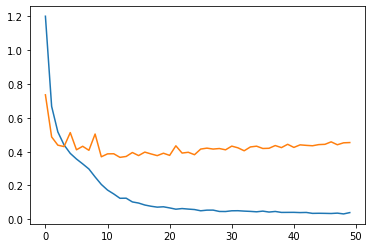

In [19]:
plt.plot(train_losses)
plt.plot(test_losses)

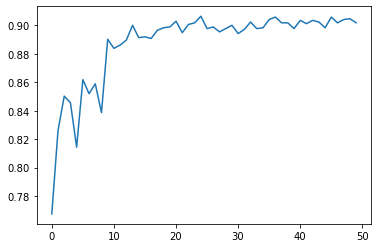

In [20]:
plt.plot(accuracies)

In [21]:
train_losses

[1.2013692372360698,
 0.6681859752533665,
 0.5170481585133188,
 0.44004949677361155,
 0.3899884643885681,
 0.35656985064304486,
 0.32786819278892193,
 0.2976758241437952,
 0.25051305294036863,
 0.20629041658220132,
 0.17291969527219053,
 0.14989667852461036,
 0.12432453124228372,
 0.12485679112649532,
 0.10277324024741406,
 0.09614711146551203,
 0.08449002946966037,
 0.07727001379664909,
 0.07193581331965722,
 0.07399537640900519,
 0.06736539613040715,
 0.0597816073304057,
 0.06354865197763009,
 0.06041733950621631,
 0.057720054183976854,
 0.050405248592318784,
 0.0541527497277084,
 0.05436308285678028,
 0.04638804024757463,
 0.046053474128720386,
 0.050334797421401595,
 0.05077923217994401,
 0.04842571902882768,
 0.046795275946371985,
 0.04435833481262322,
 0.04836652926125564,
 0.04282430770900572,
 0.04639148095559358,
 0.04070249887443244,
 0.0409174836242729,
 0.04109910714856887,
 0.039738003960228106,
 0.04053229297917344,
 0.035071148501408765,
 0.03567046892552469,
 0.03515033

In [ ]:
test_losses

In [ ]:
accuracies

# Testing

In [22]:
# Reading the Datafarme
test_data = pd.read_csv('./dataset/test_challenge.csv')
test_data = test_data.replace({'1': classes_to_idx})
test_data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [24]:
if CENTER_CROP_FIVE:
    testset = SatelliteDataset(dataroot='./dataset/test/', X_array=test_data['0'].values, Y_array=test_data['1'].values, 
                               transform=transforms.Compose([transforms.Resize(256),
                                                             transforms.FiveCrop(IMAGE_SIZE),
                                                             transforms.Lambda(lambda crops: torch.stack([
                                                                 transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                      [0.2558, 0.2532, 0.2457])(
                                                                     transforms.ToTensor()(crop)) for crop in crops]))
                                                            ]))

else:
    testset = SatelliteDataset(dataroot='./dataset/test/', X_array=test_data['0'].values, Y_array=test_data['1'].values, 
                               transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                             transforms.CenterCrop(IMAGE_SIZE),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                  [0.2558, 0.2532, 0.2457])]))

In [25]:
testsetloader = DataLoader(testset, batch_size=32, shuffle=False)

In [26]:
len(testsetloader.dataset)

596

In [27]:
def infarence_and_save(epoch):
    model.load_state_dict(torch.load(f'./models/model_{epoch}.pt'))

    y_test_pred = np.empty(0)

    model.eval()
    with torch.no_grad():
        for data in testsetloader:
            x = data['image'].to(device)
            if CENTER_CROP_FIVE:
                bs, ncrops, c, h, w = x.size()
                out = torch.exp(model(x.view(-1, c, h, w)))
                out, _ = out.argmax(1).view(bs, ncrops).median(1)
                y_test_pred = np.append(y_test_pred, out.cpu().numpy())
            else:
                out = model(x)
                out = torch.exp(out).argmax(1)
                y_test_pred = np.append(y_test_pred, out.cpu().numpy())

    y_test_pred.shape

    d = {'0': test_data['0'].values, '1': y_test_pred.astype(int)}
    pd.DataFrame(d).replace({'1': idx_to_classes}).to_csv(f'./output_{epoch}.csv', index=False)

In [ ]:
for i in range(1, 31):
    print(f"Working for epoch {i}")
    infarence_and_save(i)

Working for epoch 1
Working for epoch 2
Working for epoch 3
Working for epoch 4
Working for epoch 5
Working for epoch 6
Working for epoch 7
Working for epoch 8
Working for epoch 9
Working for epoch 10


In [ ]:
y_test_pred = np.empty(0)

model.eval()
with torch.no_grad():
    for data in testsetloader:
        x = data['image'].to(device)
        bs, ncrops, c, h, w = x.size()
        out = torch.exp(model(x.view(-1, c, h, w)))
        out = out.view(bs, ncrops, -1)
        print(out.argmax(1))
        print(out.shape)
        print(out.mean(1).argmax(1))
        break